Processing CHIME FRB180916.J0158+65
=====

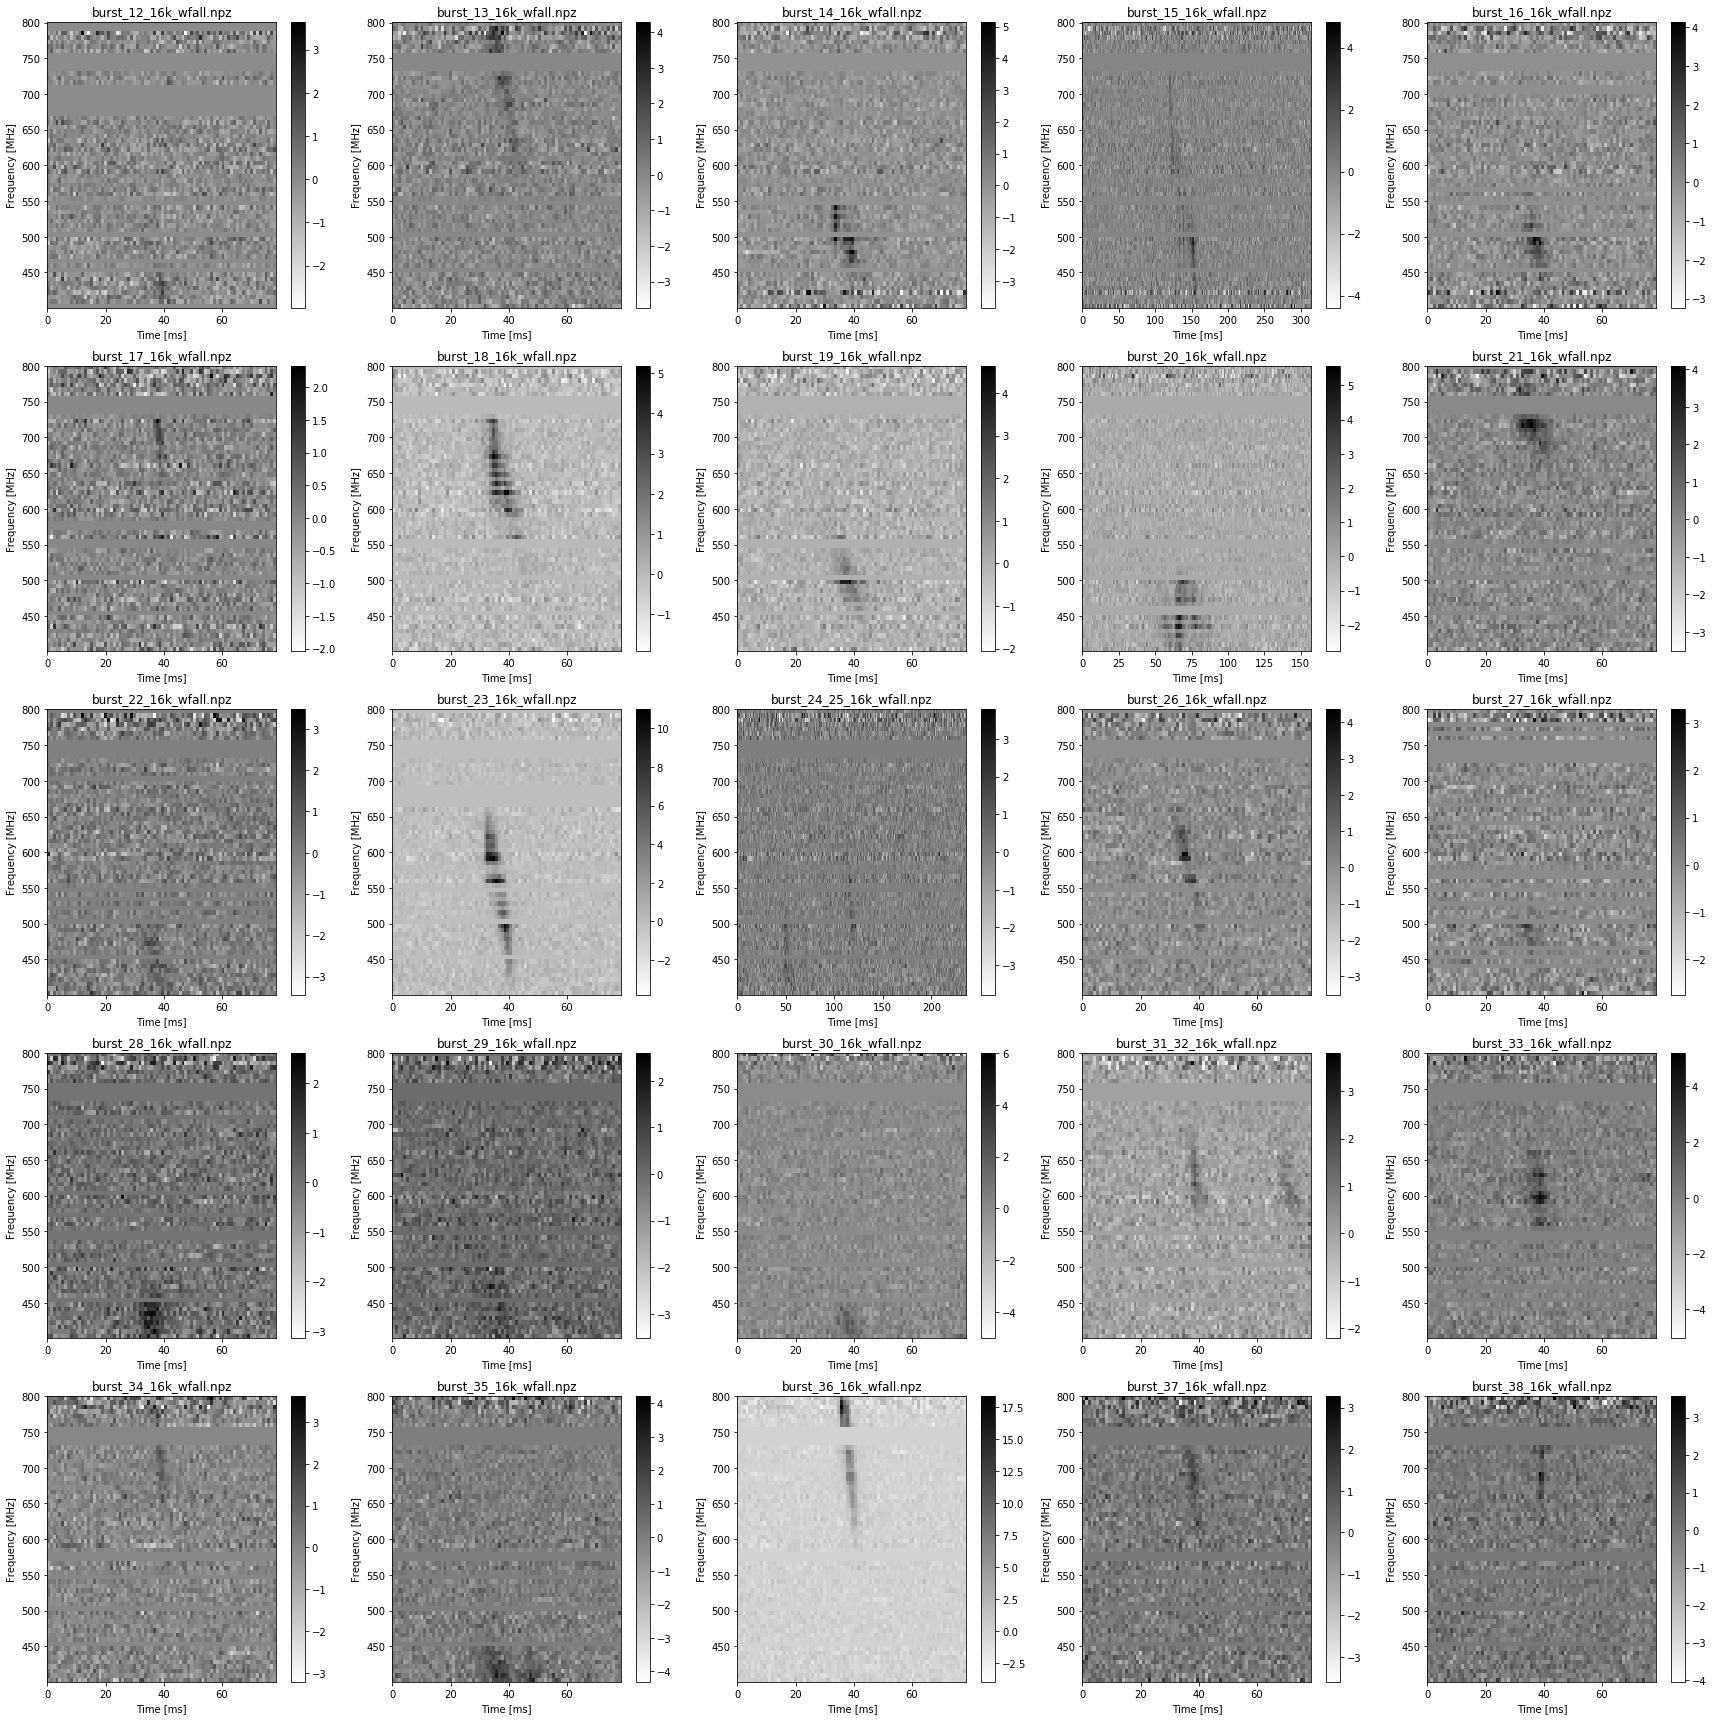

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import os
from tqdm import tqdm
import skimage.measure

folder = 'data/CHIME_180916.J0158+65'
burstfiles = [s for s in os.listdir(folder) if '16k' in s]

plt.figure(figsize=(24,24))
cmap = plt.get_cmap('gray_r')
cmap.set_bad(color = 'w', alpha = 1.)

for fname in burstfiles:
    data = np.load("{}/{}".format(folder, fname))
    wfall = data["wfall"]
    downsample = 256
    wfall_down = skimage.measure.block_reduce(np.nan_to_num(wfall), block_size=(downsample, 1), func=np.mean)
    wfall_masked = np.ma.masked_where(wfall_down == 0, wfall_down)
    # print(wfall_down.shape, wfall.shape)
    
    dt_s = data["dt_s"]
    center_freq_mhz = data["center_freq_mhz"]
    df_mhz = center_freq_mhz[1] - center_freq_mhz[0]
    # print(dt_s, center_freq_mhz[0], center_freq_mhz[-1], df_mhz)
    
    plt.subplot(5,5,burstfiles.index(fname)+1)
    plt.title(fname)
    plt.imshow(wfall_down, origin="lower", aspect="auto", interpolation="nearest", cmap=cmap,
               extent=(0, 1000*dt_s*wfall.shape[1], center_freq_mhz[0]-df_mhz/2., center_freq_mhz[-1]+df_mhz/2.))
    plt.colorbar()
    plt.xlabel("Time [ms]")
    plt.ylabel("Frequency [MHz]")

plt.tight_layout()
# plt.savefig('bursts.png')

(64, 900)
(64, 900)
(64, 600)
(64, 900)


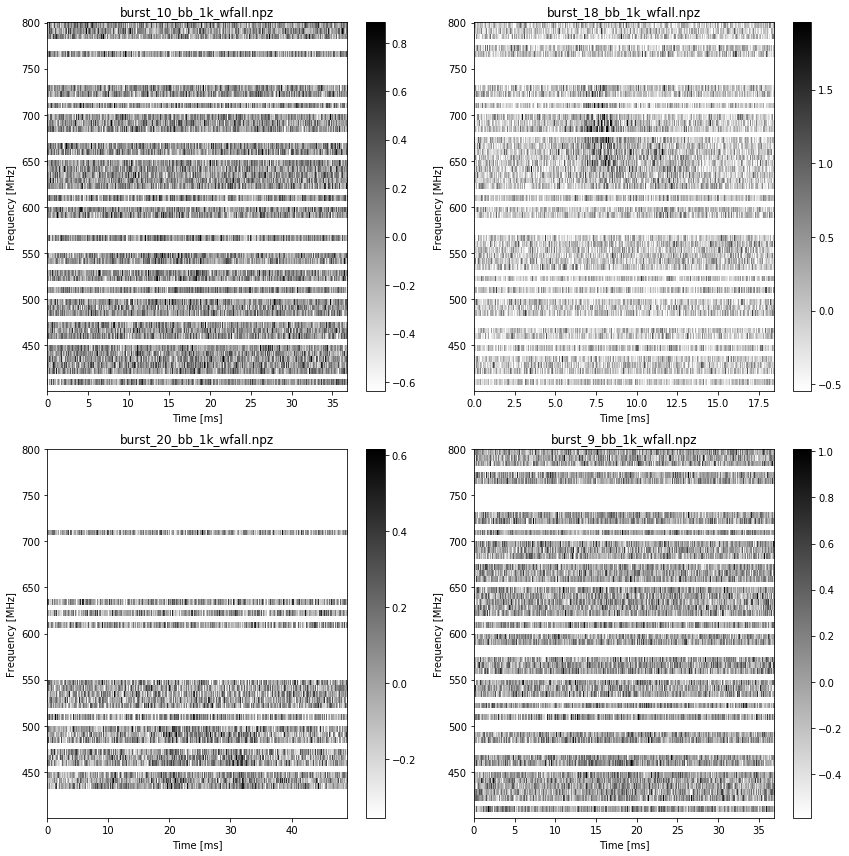

In [58]:
burstfiles = [s for s in os.listdir(folder) if 'bb' in s]

plt.figure(figsize=(12,12))
cmap = plt.get_cmap('gray_r')
cmap.set_bad(color = 'w', alpha = 1.) # potentially hides important errors in the data!

for fname in burstfiles:
    data = np.load("{}/{}".format(folder, fname))
    wfall = data["wfall"]
    wfall_z = np.nan_to_num(wfall)
    
    dt_s = data["dt_s"]
    center_freq_mhz = data["center_freq_mhz"]
    df_mhz = center_freq_mhz[1] - center_freq_mhz[0]
    
    plt.subplot(2,2,burstfiles.index(fname)+1)
 
    bb_downsample = 16
    plt.title(fname)
    plt.imshow(wfall[::16,:], origin="lower", aspect="auto", interpolation="nearest", cmap=cmap,
               extent=(0, 1000*dt_s*wfall.shape[1], center_freq_mhz[0]-df_mhz/2., center_freq_mhz[-1]+df_mhz/2.))
    plt.clim(np.min(wfall_z)*0.5, np.max(wfall_z)*0.5)
    plt.colorbar()
    plt.xlabel("Time [ms]")
    plt.ylabel("Frequency [MHz]")
    print(wfall[::16,:].shape)

plt.tight_layout()